In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.signal import detrend
import pandas as pd
from datetime import datetime

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.sortby(hadsst.latitude, ascending=True)
#rename coords
#hadsst = hadsst.rename({"lon": "longitude", "lat": "latitude"})
hadsst =hadsst.sel(time = slice("1900-01-01", "2019-12-31"))
hadsst = hadsst.compute()

In [4]:
hadsst1 = xr.where(hadsst == -1000, np.nan, hadsst)

In [5]:
anoms = (hadsst1.groupby('time.month') - hadsst1.groupby('time.month').mean('time')).drop('month')

In [6]:
da = anoms

In [7]:
#add times back to 1850 to fill in later
new_time = pd.date_range('1850-01-16', '1900-01-16', freq='M')

# create a new data array with zeros and the same dimensions as the original array
new_data = np.zeros((len(new_time)))
new_data[:] = np.nan #delete if i want to go back to zeros in middle

# create a new xarray DataArray with the new time index and the zero-filled data
new_array = xr.DataArray(new_data, coords=[new_time], dims=['time'])

# concatenate the new array with the original array along the time dimension
concatenated_array = xr.concat([new_array, da], dim='time')

In [8]:
# create a new time coordinate with monthly frequency for the years 1780-1800
new_times = pd.date_range(start='1680-01', end='1850-1', freq='M')
# create a new DataArray with the time coordinate and fill with NaNs
da_1680_1849 = xr.DataArray(data=np.nan, dims=('time', 'lat', 'lon'), coords={'time': new_times})

# select the slice of data from 1900 to 2020
da_1850_2020 = concatenated_array.sel(time=slice('1850-01-01', '2019-12-31'))

# reverse the order of the data along the time axis
da_1680_1849_data = da_1850_2020.isel(time=slice(None, None, -1))

# update the time coordinate to reflect the new time period
da_1680_1849_data['time'] = new_times

# reindex the data to add the new months from 1780-1800
da_1680_1849_data = da_1680_1849_data.reindex(time=da_1680_1849.time)

# concatenate the three slices along the time axis to get the final DataArray
da_symmetric = xr.concat([da_1680_1849_data, da_1850_2020], dim='time')

In [9]:
pv = da_symmetric.polyfit(dim = 'time', deg = 2)
#this fits a polynomial of degree 2 to the symetric dataset

In [10]:
q = xr.polyval(da_symmetric.time, pv)

In [12]:
#calcualte change in trend from Jan 2005 to jan1850
delta_q =  q.polyfit_coefficients[-(15*12)-1] - q.polyfit_coefficients[12*170]

In [12]:
#Modern day climatology is 1990-2019
mod_clim = hadsst1.sel(time=slice("1990-01-01", "2019-12-31")).groupby('time.month').mean('time')

In [13]:
detrended_clim = mod_clim - delta_q

In [14]:
#save detrended clim in normal grid

In [18]:
detrend_sst =  hadsst1.sel(time=slice("1950-01-01", "2019-12-31")) - delta_q

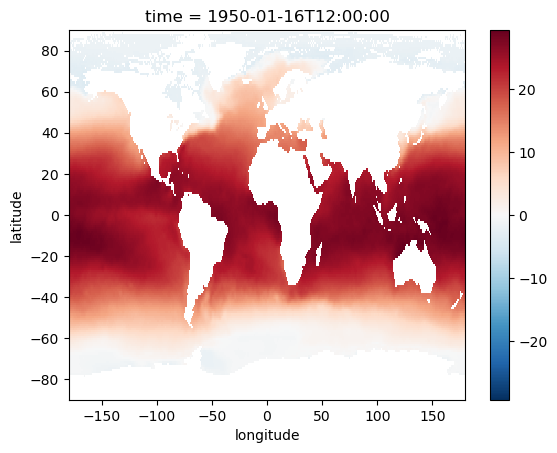

In [19]:
detrend_sst[0].plot()

In [21]:
detrend_sst.to_netcdf("/g/data/e14/sm2435/Pacemaker/detrend_hadisst_1x1.nc")

In [15]:
detrended_clim.to_netcdf("/g/data/e14/sm2435/Pacemaker/hadisst_clim_1x1.nc")

In [16]:
#make figures that show what we did

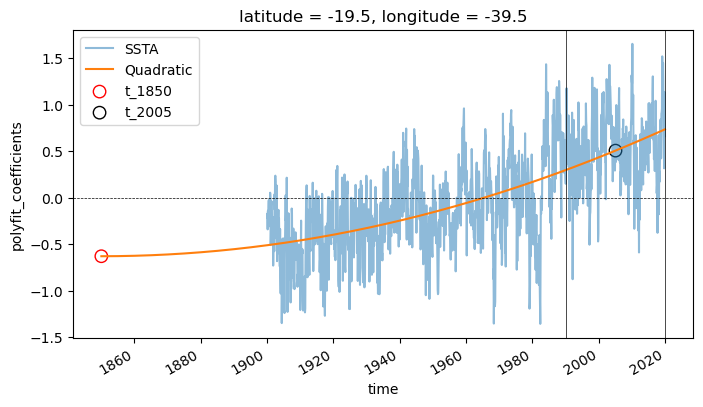

In [17]:
plt.figure(figsize = (8,4))
anoms.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'SSTA', alpha = 0.5)
q.polyfit_coefficients.sel(time=slice("1850-01-01", "2019-12-31")).sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'Quadratic')
plt.scatter(q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').time, 
            q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').values, s=80, facecolors='none', edgecolors='r', label = 't_1850')
plt.scatter(q.polyfit_coefficients[-15*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').time, 
            q.polyfit_coefficients[-15*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').values, s=80, facecolors='none', edgecolors='k', label = 't_2005')

plt.axvline(datetime.strptime("1990-01-01", "%Y-%m-%d"), color = 'k', linestyle = '-', linewidth = 0.5)
plt.axvline(datetime.strptime("2019-12-31", "%Y-%m-%d"), color = 'k', linestyle = '-', linewidth = 0.5)
plt.axhline(0, color = 'k', linestyle = '--', linewidth = 0.5)

plt.legend()


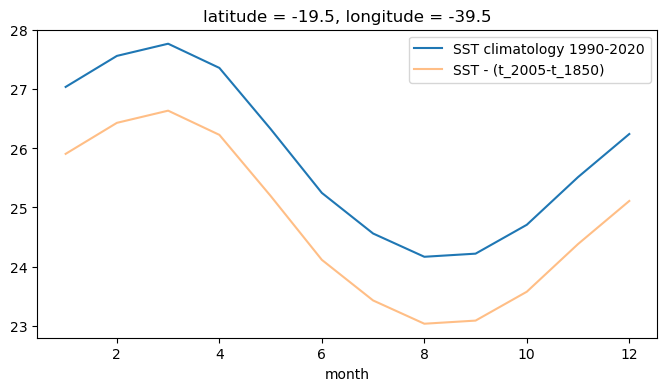

In [18]:
plt.figure(figsize = (8,4))
mod_clim.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST climatology 1990-2020")
detrended_clim.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST - (t_2005-t_1850)", alpha = 0.5)

plt.legend()

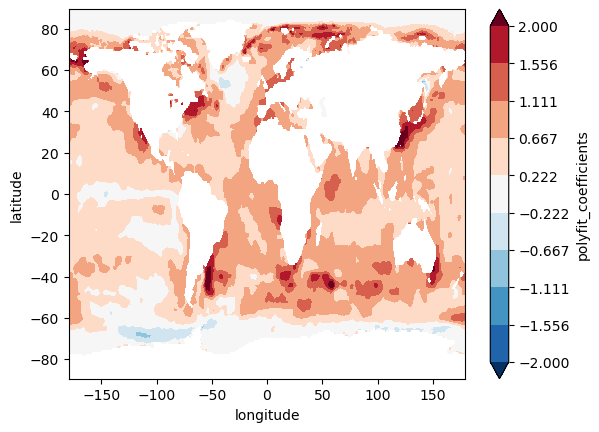

In [19]:
delta_q.plot.contourf(levels = 10, vmin = -2, vmax = 2, cmap = 'RdBu_r', extend = 'both')

In [20]:
#now we need to "remove" some land points and regrid
# Create a mask of NaN values
nan_mask = np.isnan(detrended_clim[0])

# Create a mask of ocean points (i.e., non-NaN)
ocean_mask = (~nan_mask)
# Create a mask of points that are NaN and surrounded by at least one ocean point
replace_mask = nan_mask & (
    ocean_mask.shift(latitude=1, fill_value=False) | 
    ocean_mask.shift(latitude=-1, fill_value=False) | 
    ocean_mask.shift(longitude=1, fill_value=False) | 
    ocean_mask.shift(longitude=-1, fill_value=False) | 
    ocean_mask.shift(latitude=1, longitude=1, fill_value=False) | 
    ocean_mask.shift(latitude=1, longitude=-1, fill_value=False) | 
    ocean_mask.shift(latitude=-1, longitude=-1, fill_value=False) | 
    ocean_mask.shift(latitude=-1, longitude=1, fill_value=False)
)

In [21]:
#calculate replacement values by generating a 3x3 mean box for each cell
rep = detrended_clim.rolling(latitude=3, longitude=3, center=True, min_periods=1).mean()

In [22]:
detrended_clim_coast = detrended_clim.where(~replace_mask, rep)

In [23]:
#write regridder

In [24]:
#Fetch ACCESS-CM2 grid data from last experiment
model_clim = xr.open_dataset("/g/data/w97/zg0866/pacemaker/global_sst_restoring_cm000_climatology_0951-1150.nc", decode_times=False)

In [25]:
model_clim

<xarray.Dataset>
Dimensions:   (TIME: 12, DEPTH1_1: 1, GRID_Y_T: 300, GRID_X_T: 360)
Coordinates:
  * TIME      (TIME) float64 15.0 44.0 73.5 104.0 ... 257.0 287.5 318.5 349.0
  * DEPTH1_1  (DEPTH1_1) float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Data variables:
    temp      (TIME, DEPTH1_1, GRID_Y_T, GRID_X_T) float32 ...
Attributes:
    description:  Monthly SST climatology from years 951-1150 of ACCESS-CM2 p...
    history:      Created 28/11/22

In [26]:
grid_in = xe.util.grid_global(1,1)

In [27]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], model_clim.GRID_Y_T.values, {"units": "degrees_north"}),
        "lon": (["lon"], model_clim.GRID_X_T.values, {"units": "degrees_east"}),
    }
)
ds_out


<xarray.Dataset>
Dimensions:  (lat: 300, lon: 360)
Coordinates:
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * lon      (lon) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
Data variables:
    *empty*

In [28]:
#grid_in = {'lon': detrended_clim.longitude.values, 'lat': detrended_clim.latitude.values}

In [29]:
#grid_out = {'lon': model_clim.GRID_X_T.values, 'lat': model_clim.GRID_Y_T.values}

In [30]:
RG = xe.Regridder(grid_in, ds_out, method = 'conservative_normed', periodic=True)

In [31]:
RG

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_180x360_300x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (180, 360) 
Output grid shape:          (300, 360) 
Periodic in longitude?      False

In [32]:
def regrid_meta(da):
    da = RG(da)
    da = da.rename({"lon": "GRID_X_T", "lat": "GRID_Y_T", "month": "TIME"})
    da = da.expand_dims(dim =  {"DEPTH1_1":model_clim.DEPTH1_1})
    da = da.assign_coords({"GRID_X_T": model_clim.GRID_X_T, "GRID_Y_T": model_clim.GRID_Y_T, "TIME":model_clim.TIME, "DEPTH1_1":model_clim.DEPTH1_1})
    da = da.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
    da = da.to_dataset(name = 'temp')
    da = da.assign_attrs({"description": "Monthly HadISST climatology (Jan 1900- Dec 2019 inclusive). Detrended back to 1850 using the quadratic trend T2005-T1850. For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 26/04/23"})
    da = da[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
    return da

In [33]:
regrid_coast = regrid_meta(detrended_clim_coast)
regrid_clim  = regrid_meta(detrended_clim)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('latitude', 'longitude') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('latitude', 'longitude') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


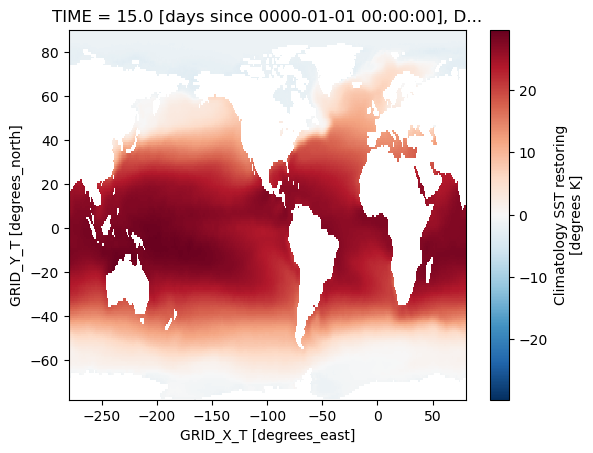

In [34]:
regrid_clim.temp[0,0].plot()

In [35]:
regrid_coast = regrid_coast.where(np.isnan(model_clim['temp'][0,0]) == 0)

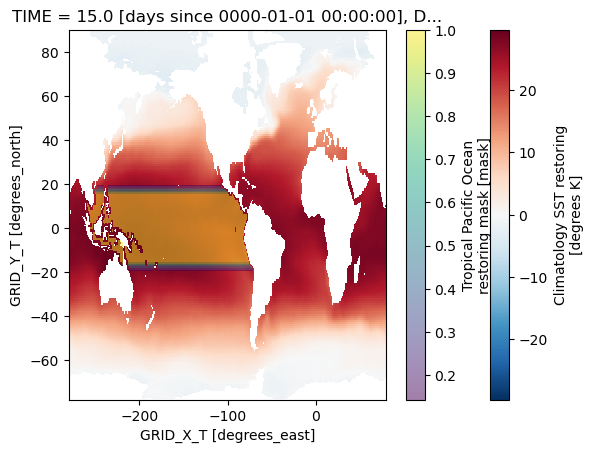

In [41]:
regrid_coast.temp[0,0].plot()
mask.restore_mask[0,0].where(mask.restore_mask[0,0]>0).plot(alpha = 0.5)

In [34]:
sst_R = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology.nc", decode_times=False)

In [40]:
mask = xr.open_dataset("/g/data/w97/zg0866/pacemaker/sst_restore_mask_tropical_Pacific_Ocean_15S-15N_5degdampimg.nc", decode_times=False)

In [39]:
ds = xr.open_dataset('/g/data/access/access-cm2/input_O1/mom4/basin_mask_20111103.nc')

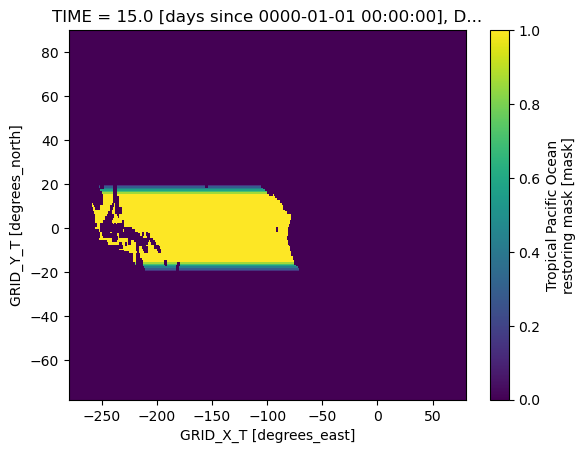

In [40]:
mask.restore_mask[0,0].plot()

In [37]:
regrid_coast

<xarray.Dataset>
Dimensions:   (DEPTH1_1: 1, TIME: 12, GRID_Y_T: 300, GRID_X_T: 360)
Coordinates:
  * TIME      (TIME) float64 15.0 44.0 73.5 104.0 ... 257.0 287.5 318.5 349.0
  * DEPTH1_1  (DEPTH1_1) float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Data variables:
    temp      (DEPTH1_1, TIME, GRID_Y_T, GRID_X_T) float64 nan nan ... nan nan
Attributes:
    description:  Monthly HadISST climatology (Jan 1990- Dec 2019 inclusive)....
    history:      Created 26/04/23

In [39]:
regrid_coast.to_netcdf("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology.nc", encoding = {"TIME": {"_FillValue": None},
                                                                                    "DEPTH1_1": {"_FillValue": None},
                                                                                    "GRID_Y_T": {"_FillValue": None},
                                                                                    "GRID_X_T": {"_FillValue": None},
                                                                                    "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

SyntaxError: invalid syntax (3983105699.py, line 5)

In [35]:
#load in ACCESS-CM2 SST data

In [41]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {'time':12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [55]:
ctrl_sst.xt_ocean

<xarray.DataArray 'xt_ocean' (xt_ocean: 360)>
array([-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X

In [54]:
ctrl_sst.geolon_t

<xarray.DataArray 'geolon_t' (yt_ocean: 300, xt_ocean: 360)>
dask.array<open_dataset-7049777e870c3960e42e5e7e23b0d95egeolon_t, shape=(300, 360), dtype=float32, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    long_name:     tracer longitude
    units:         degrees_E
    valid_range:   [-281.  361.]
    cell_methods:  time: point

In [43]:
ctrl = ctrl_sst['sst']

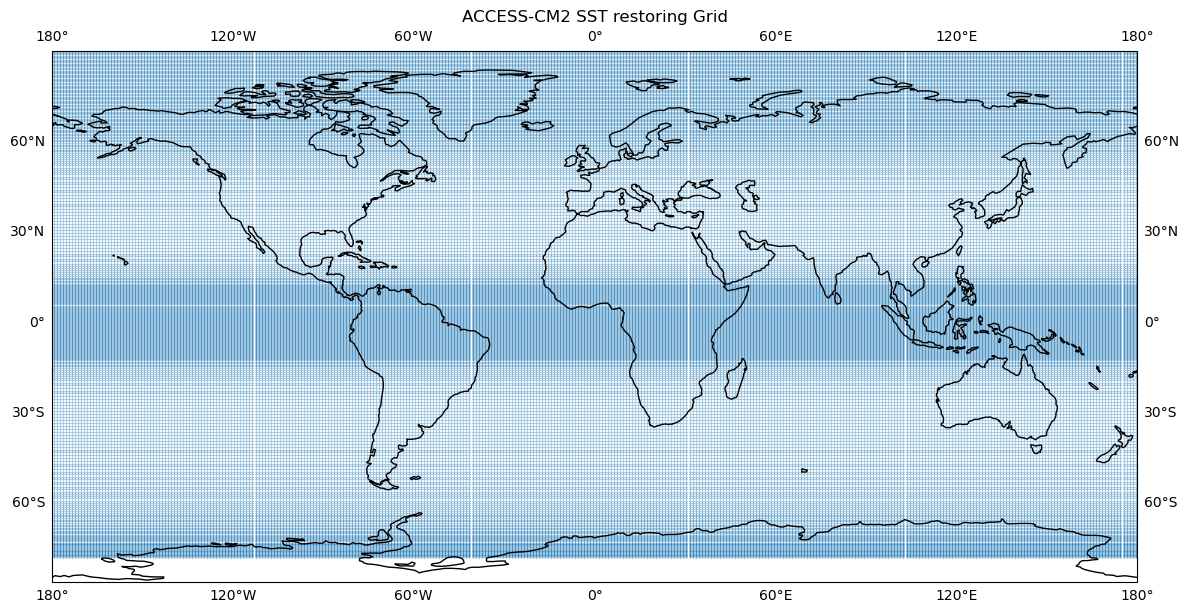

In [45]:
projection = ccrs.cartopy.crs.PlateCarree()
fig, axes = plt.subplots(ncols = 1, subplot_kw={'projection': projection}, figsize = (14, 8))

axes.scatter(np.tile(ctrl_sst['xt_ocean'], 300).reshape(300,360), np.repeat(ctrl_sst['yt_ocean'], 360).values.reshape(300,360), s = 0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes.set_title('ACCESS-CM2 SST restoring Grid')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0, linestyle='--')
axes.coastlines()

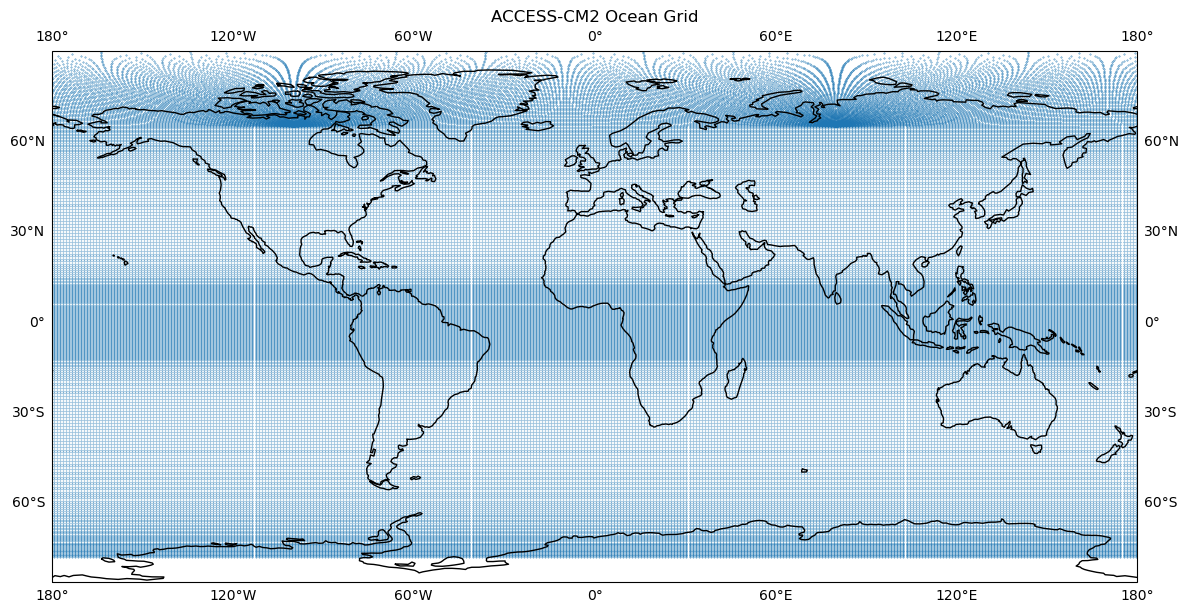

In [44]:
projection = ccrs.cartopy.crs.PlateCarree()
fig, axes = plt.subplots(ncols = 1, subplot_kw={'projection': projection}, figsize = (14, 8))

axes.scatter(ctrl_sst['geolon_t'], ctrl_sst['geolat_t'], s = 0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes.set_title('ACCESS-CM2 Ocean Grid')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0, linestyle='--')
axes.coastlines()

In [126]:
#now we take ctrl_sst off the tripolar grid
ctrl = ctrl.rename({"xt_ocean": "GRID_X_T", "yt_ocean": "GRID_Y_T", "time":"TIME"})
ctrl = ctrl.drop({'geolon_t', 'geolat_t'})
ctrl = ctrl.expand_dims(dim =  {"DEPTH1_1":model_clim.DEPTH1_1})

In [127]:
#now we need to give the grid xt and grid yt the correct metadata
ctrl = ctrl.assign_coords({"GRID_X_T": model_clim.GRID_X_T, "GRID_Y_T": model_clim.GRID_Y_T, "DEPTH1_1":model_clim.DEPTH1_1})

In [128]:
ctrl_mean = ctrl.groupby('TIME.month').mean('TIME')

In [129]:
ctrl_anoms = (ctrl.groupby('TIME.month') - ctrl.groupby('TIME.month').mean('TIME')).drop('month')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [ ]:
#Now time to loop through the ctrl_anoms and make many cliamtology files

In [115]:
year_data

<xarray.DataArray 'sst' (DEPTH1_1: 1, time: 12, GRID_Y_T: 300, GRID_X_T: 360)>
dask.array<getitem, shape=(1, 12, 300, 360), dtype=float32, chunksize=(1, 12, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * DEPTH1_1  (DEPTH1_1) float64 0.0
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 0950-01-16 12:00:00 ... 0950-12-16 12:00:00

In [137]:
grouped_data = ctrl_anoms.groupby('TIME.year')
year_dict={}
# loop through each year and create a new dataarray
for year, data in grouped_data:
    # create new dataarray for the current year
    year_data = data.copy()
    # update time coordinate to only include one year
    year_data = year_data.assign_coords({"TIME":model_clim.TIME})
    #add Observed cliamtology to the year_data
    year_data = year_data + regrid_coast['temp']
    # add new dataarray to a dictionary, using year as the key
    year_dict[year] = year_data

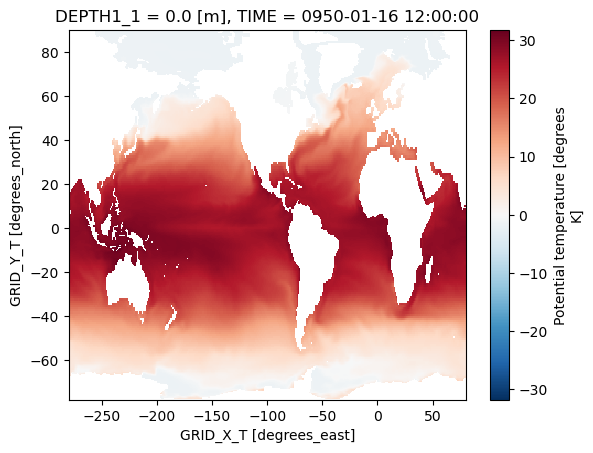

In [141]:
ctrl[0,0].plot()

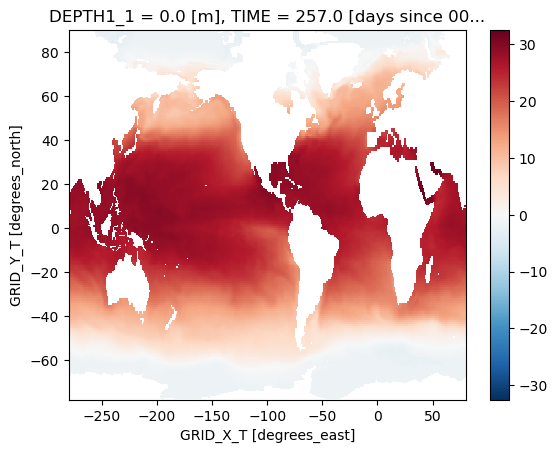

In [143]:
year_dict[950][0][8].plot()

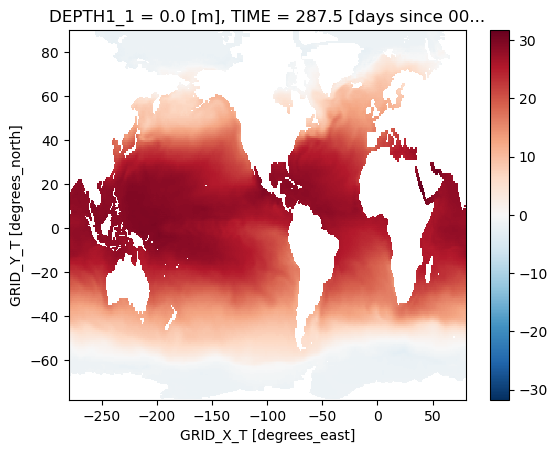

In [144]:
year_dict[950][0][9].plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 9.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


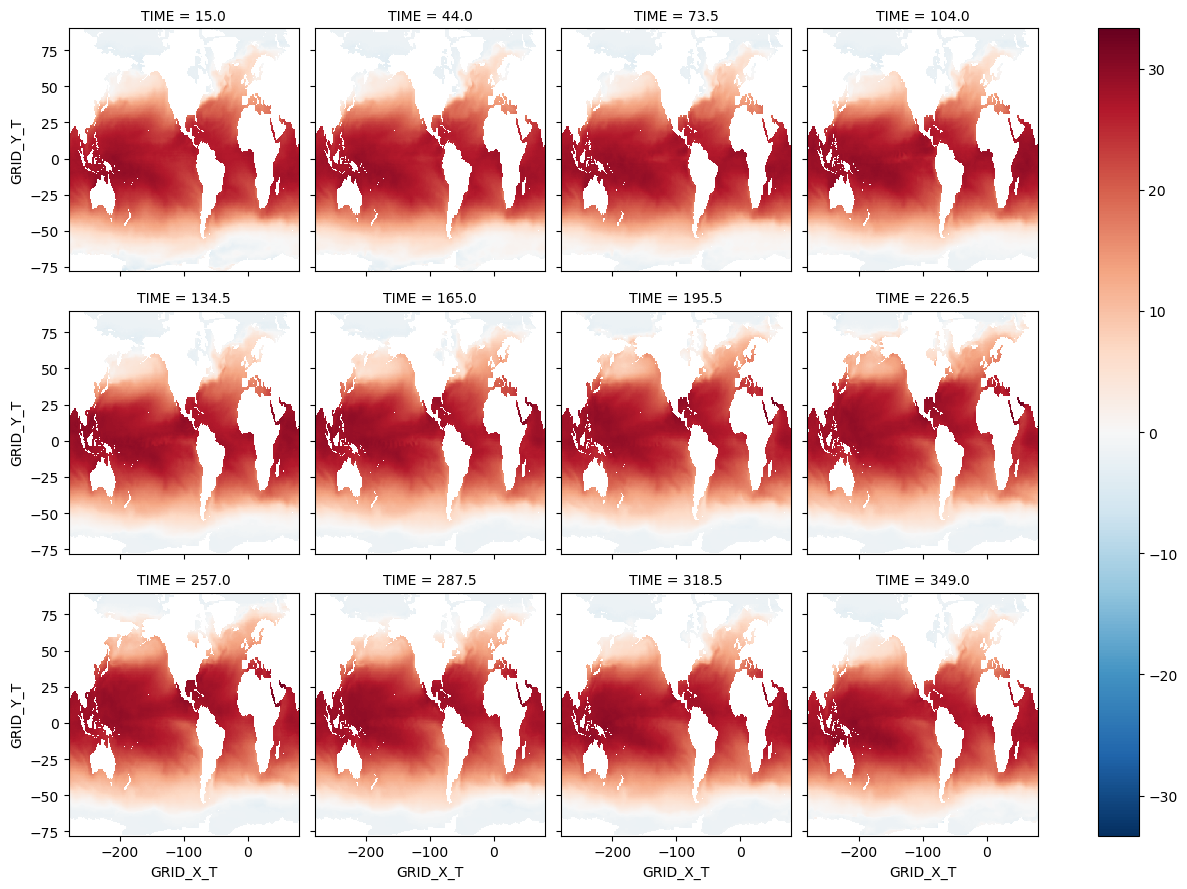

In [142]:
year_dict[950][0].plot(col = "TIME", col_wrap = 4)

In [65]:
lonb = np.zeros_like(model_clim.GRID_X_T.values)
latb = np.zeros_like(model_clim.GRID_Y_T.values)
lonb[:-1] = (model_clim.GRID_X_T.values[:-1] + model_clim.GRID_X_T.values[1:]) / 2
latb[:-1] = (model_clim.GRID_Y_T.values[:-1] + model_clim.GRID_Y_T.values[1:]) / 2
grid_out = {'lon': model_clim.GRID_X_T.values, 'lat': model_clim.GRID_Y_T.values,
           'lon_b': lonb,
           'lat_b': latb}

In [69]:
ds_out2 = xr.Dataset(
    {
        "lat": (["lat"], model_clim.GRID_Y_T.values, {"units": "degrees_north"}),
        "lon": (["lon"], model_clim.GRID_X_T.values, {"units": "degrees_east"}),
        "lat_b": (["lat_b"], (model_clim.GRID_Y_T.values[:-1] + model_clim.GRID_Y_T.values[1:]) / 2, {"units": "degrees_north"}), 
        "lon_b": (["lon_b"], (model_clim.GRID_X_T.values[:-1] + model_clim.GRID_X_T.values[1:]) / 2, {"units": "degrees_east"})
    }
)
ds_out2


<xarray.Dataset>
Dimensions:  (lat: 300, lon: 360, lat_b: 299, lon_b: 359)
Coordinates:
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * lon      (lon) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
  * lat_b    (lat_b) float64 -77.75 -77.51 -77.26 -77.01 ... 88.65 89.1 89.55
  * lon_b    (lon_b) float64 -279.0 -278.0 -277.0 -276.0 ... 76.0 77.0 78.0 79.0
Data variables:
    *empty*

In [59]:
####lets rename the coordinate sin the model_clim varibale
MC = model_clim.temp

In [94]:
MC.cf

Coordinates:
             CF Axes: * X: ['GRID_X_T']
                      * Y: ['GRID_Y_T']
                      * Z: ['DEPTH1_1']
                      * T: ['TIME']

      CF Coordinates: * longitude: ['GRID_X_T']
                      * latitude: ['GRID_Y_T']
                      * vertical: ['DEPTH1_1']
                      * time: ['TIME']

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

In [92]:
ctrl

<xarray.DataArray 'sst' (time: 2412, yt_ocean: 300, xt_ocean: 360)>
dask.array<open_dataset-7049777e870c3960e42e5e7e23b0d95esst, shape=(2412, 300, 360), dtype=float32, chunksize=(12, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    long_name:      Potential temperature
    units:          degrees K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [95]:
test = ctrl.rename({"xt_ocean": "longitude", "yt_ocean": "latitude"})
test = test.drop({'geolon_t', 'geolat_t'})
test.cf

Coordinates:
             CF Axes: * X: ['longitude']
                      * Y: ['latitude']
                      * T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['longitude']
                      * latitude: ['latitude']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

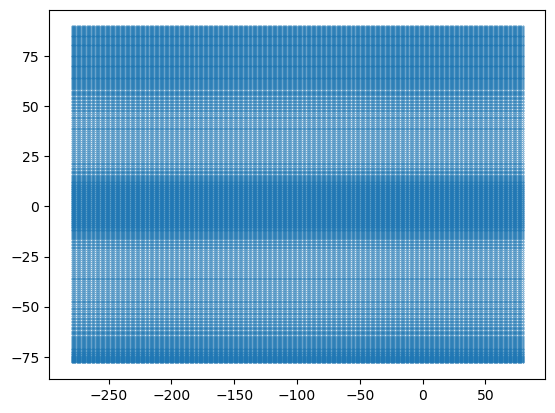

In [58]:
plt.scatter(np.tile(ctrl['xt_ocean'], 300).reshape(300,360), np.repeat(ctrl['yt_ocean'], 360).values.reshape(300,360), s = 0.1)#, transform=ccrs.PlateCarree()) 

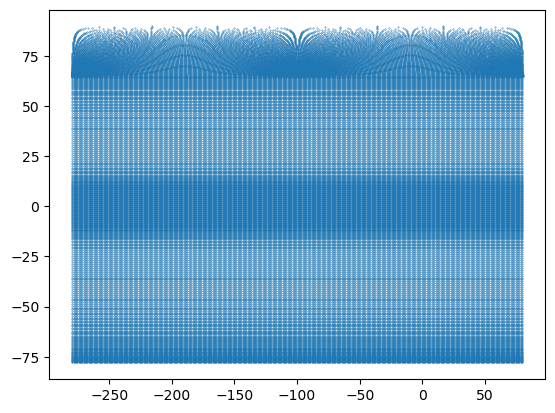

In [57]:
plt.scatter(ctrl['geolon_t'], ctrl['geolat_t'], s = 0.1)

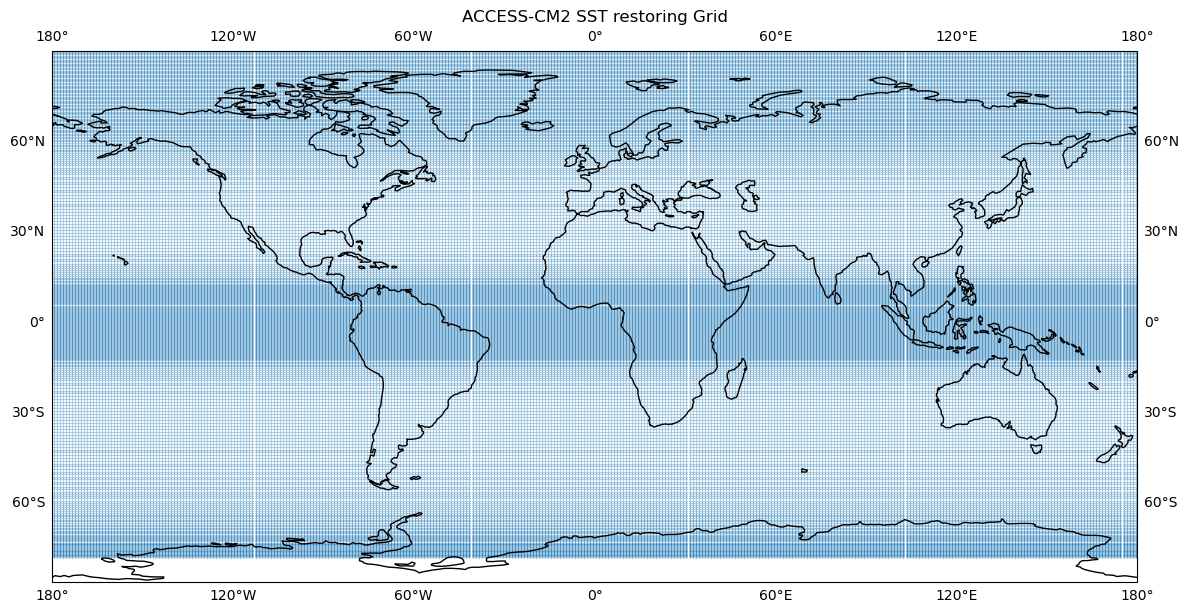

In [91]:
projection = ccrs.cartopy.crs.PlateCarree()
fig, axes = plt.subplots(ncols = 1, subplot_kw={'projection': projection}, figsize = (14, 8))

axes.scatter(np.tile(test['longitude'], 300).reshape(300,360), np.repeat(test['latitude'], 360).values.reshape(300,360), s = 0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes.set_title('ACCESS-CM2 SST restoring Grid')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0, linestyle='--')
axes.coastlines()

In [64]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 360)
Coordinates:
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * lon      (lon) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
Data variables:
    *empty*

In [85]:
RG = xe.Regridder(test, ds_out, "conservative_normed")

KeyError: 'lon_b'

In [ ]:
test4 = RG(ctrl_anoms)

In [76]:
test2.compute()

<xarray.DataArray (time: 2412, lat: 300, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * lon      (lon) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
Attributes:
    regrid_method:  bilinear

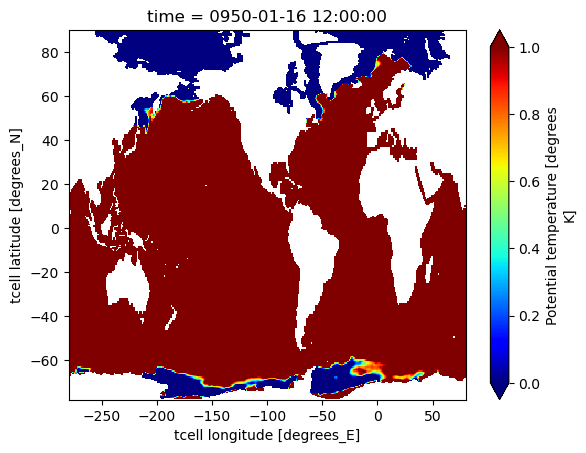

In [88]:
test[0].plot(vmin = 0, vmax = 1, cmap = 'jet')

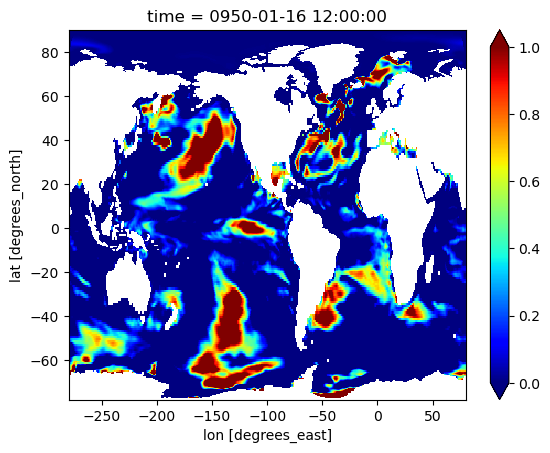

In [84]:
test3[0].plot(vmin = 0, vmax = 1, cmap = 'jet')

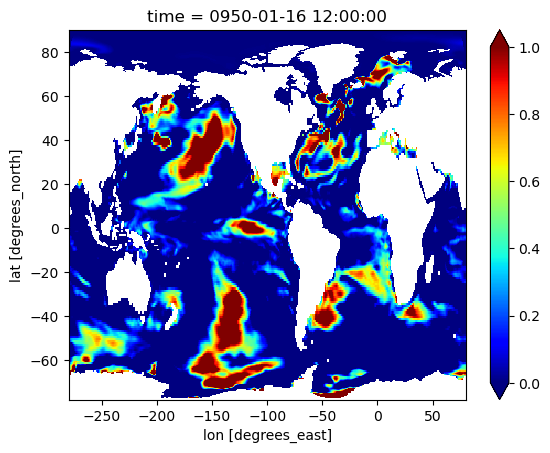

In [77]:
test2[0].plot(vmin = 0, vmax = 1, cmap = 'jet')

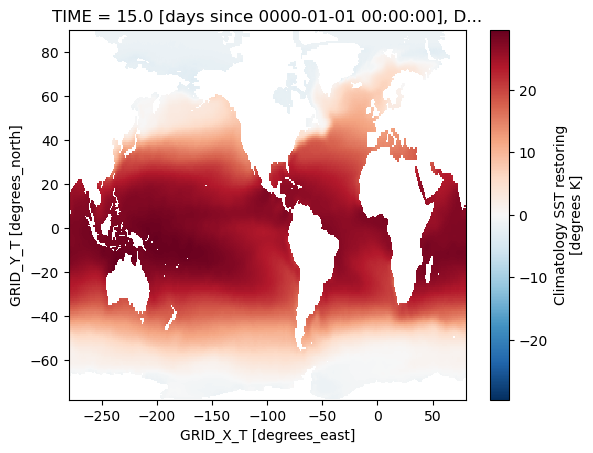

In [55]:
regrid_coast.temp[0,0].plot()

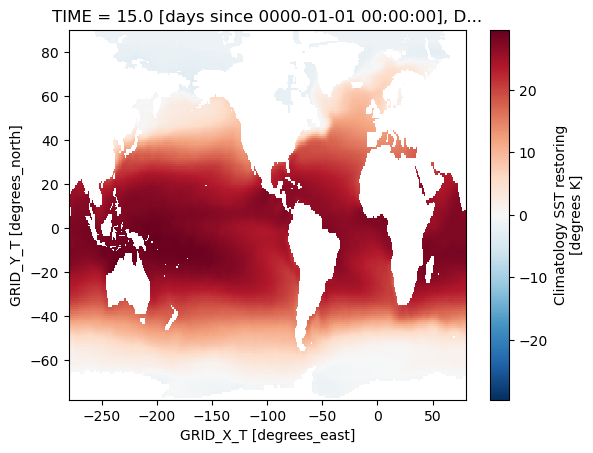

In [43]:
regrid_clim.where(np.isnan(model_clim['temp'][0,0]) == 0)['temp'][0,0].plot()

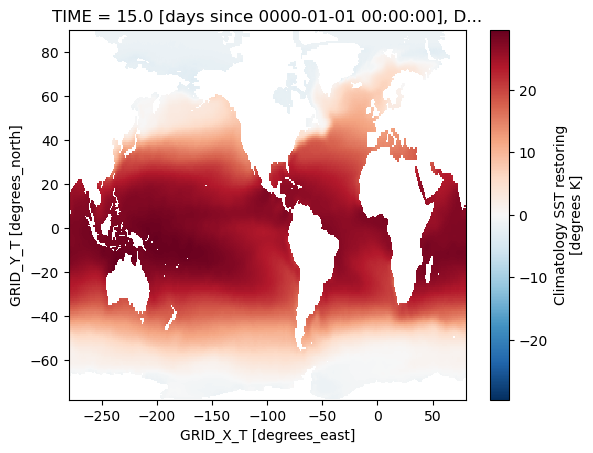

In [44]:
regrid_coast.where(np.isnan(model_clim['temp'][0,0]) == 0)['temp'][0,0].plot()

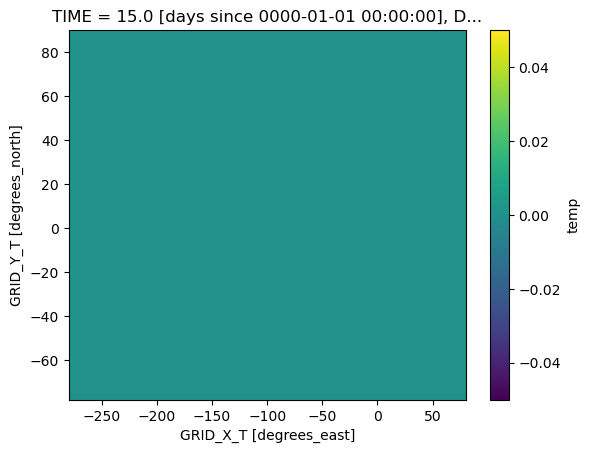

In [57]:
#regrid_coast.where(np.isnan(regrid_coast['temp'][0,0])==0)['temp'][0,0].plot()
(xr.where(regrid_coast, 1, 0)['temp'][0,0] - xr.where(model_clim, 1, 0)['temp'][0,0]).plot()

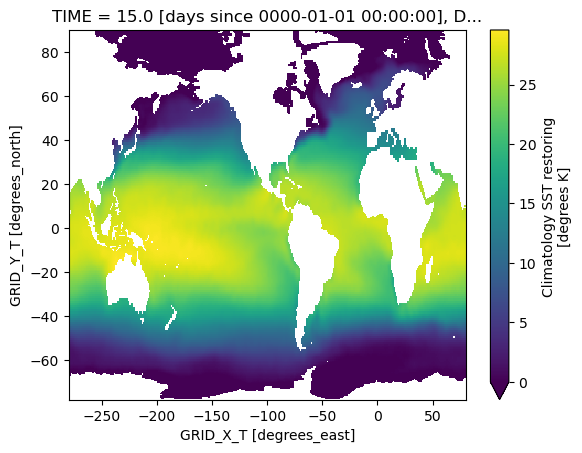

In [40]:
regrid_coast.where(np.isnan(model_clim['temp'][0,0]) == 0)['temp'][0,0].plot(vmin = 0)

In [77]:
test['temp'].mean("TIME")[0]

<xarray.DataArray 'temp' (GRID_Y_T: 300, GRID_X_T: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    DEPTH1_1  float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5

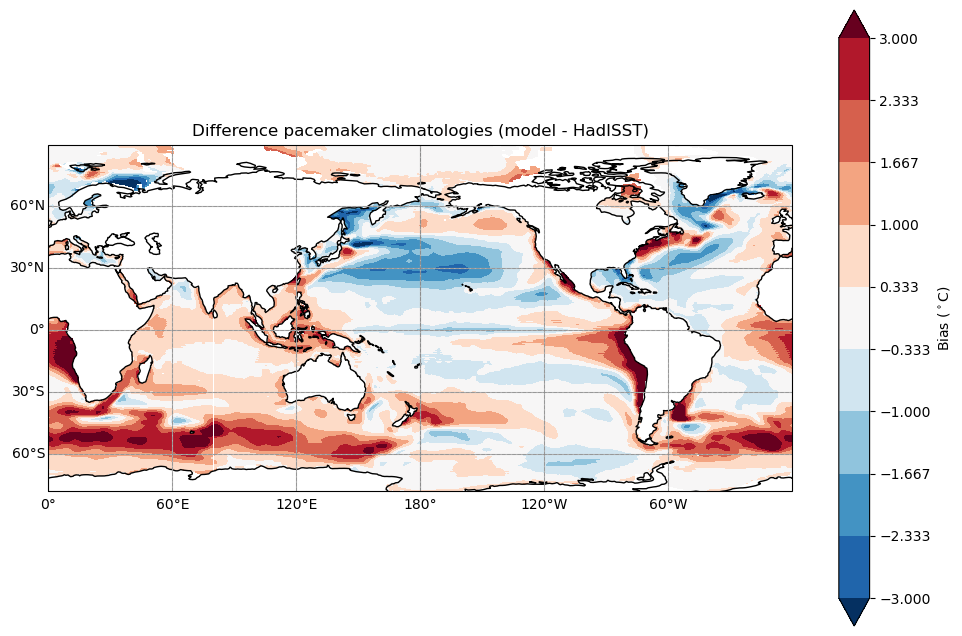

In [38]:
bias = (model_clim['temp'][:,0].mean("TIME") - regrid_coast['temp'][0,:].mean('TIME'))
plt.figure(figsize = (12,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
bias.plot.contourf(ax=ax, vmin = -3, vmax = 3, cmap = "RdBu_r", levels = 10, extend = 'both',
       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
ax.set_title('Difference pacemaker climatologies (model - HadISST)')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


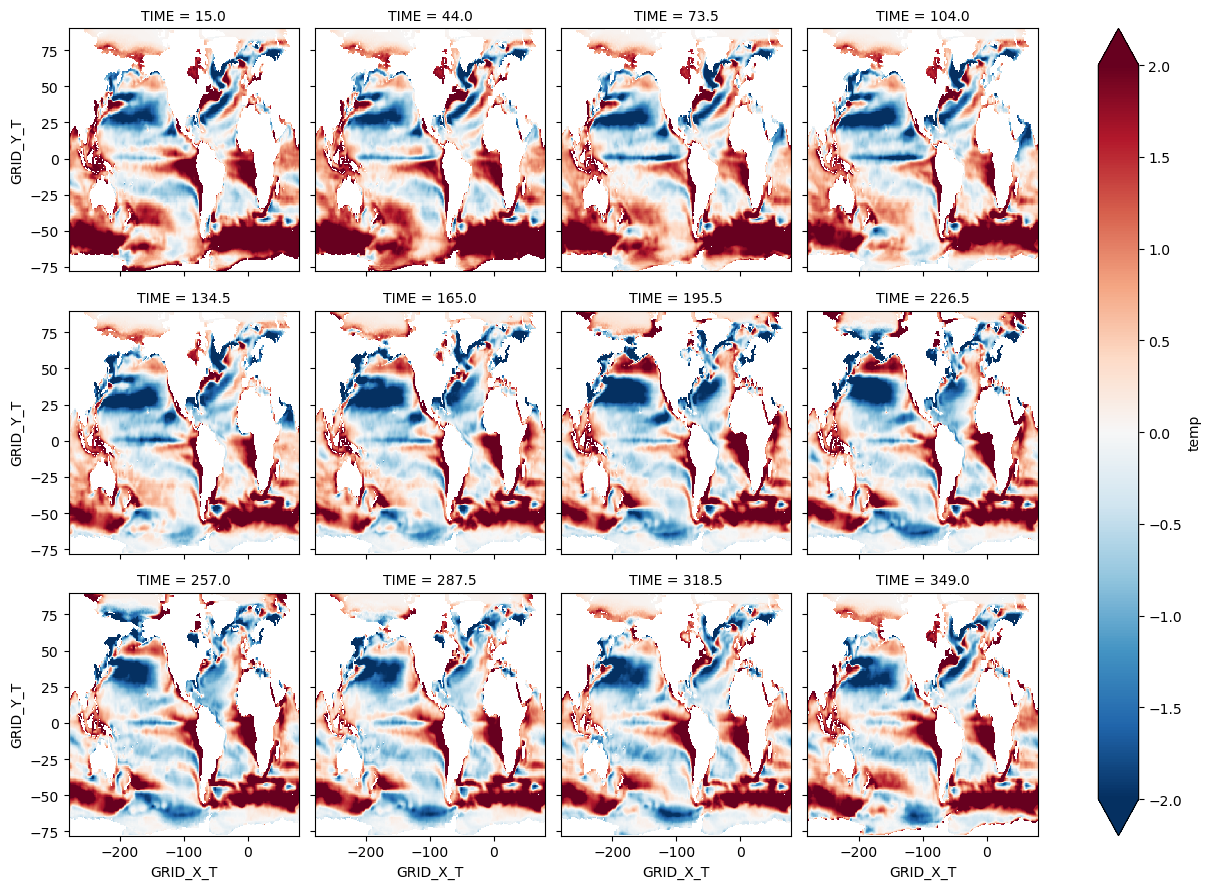

In [61]:
(model_clim['temp'] - test['temp'])[:,0].plot(col = 'TIME', col_wrap = 4, vmin = -2, vmax = 2, cmap = 'RdBu_r')

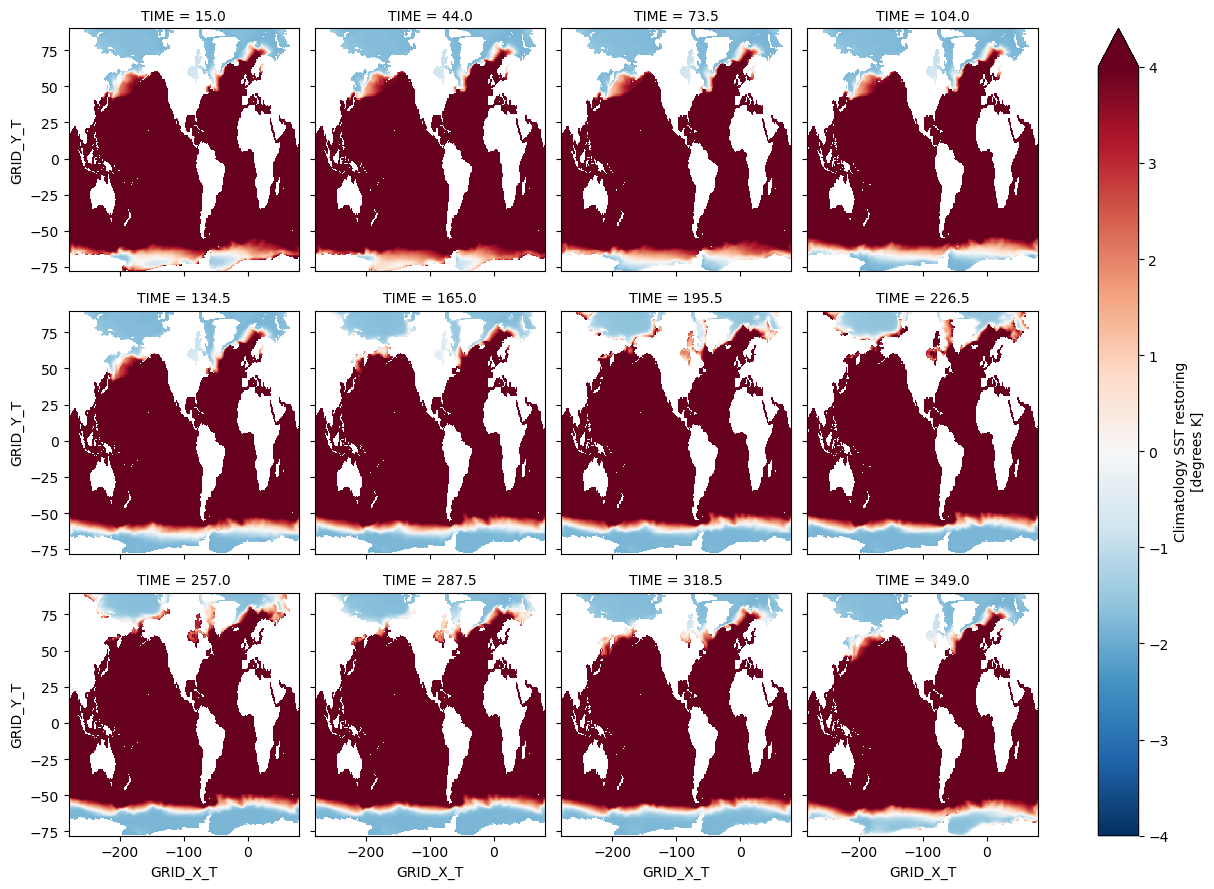

In [53]:
(model_clim['temp'])[:,0].plot(col = 'TIME', col_wrap = 4, vmin = -4, vmax = 4, cmap = 'RdBu_r')

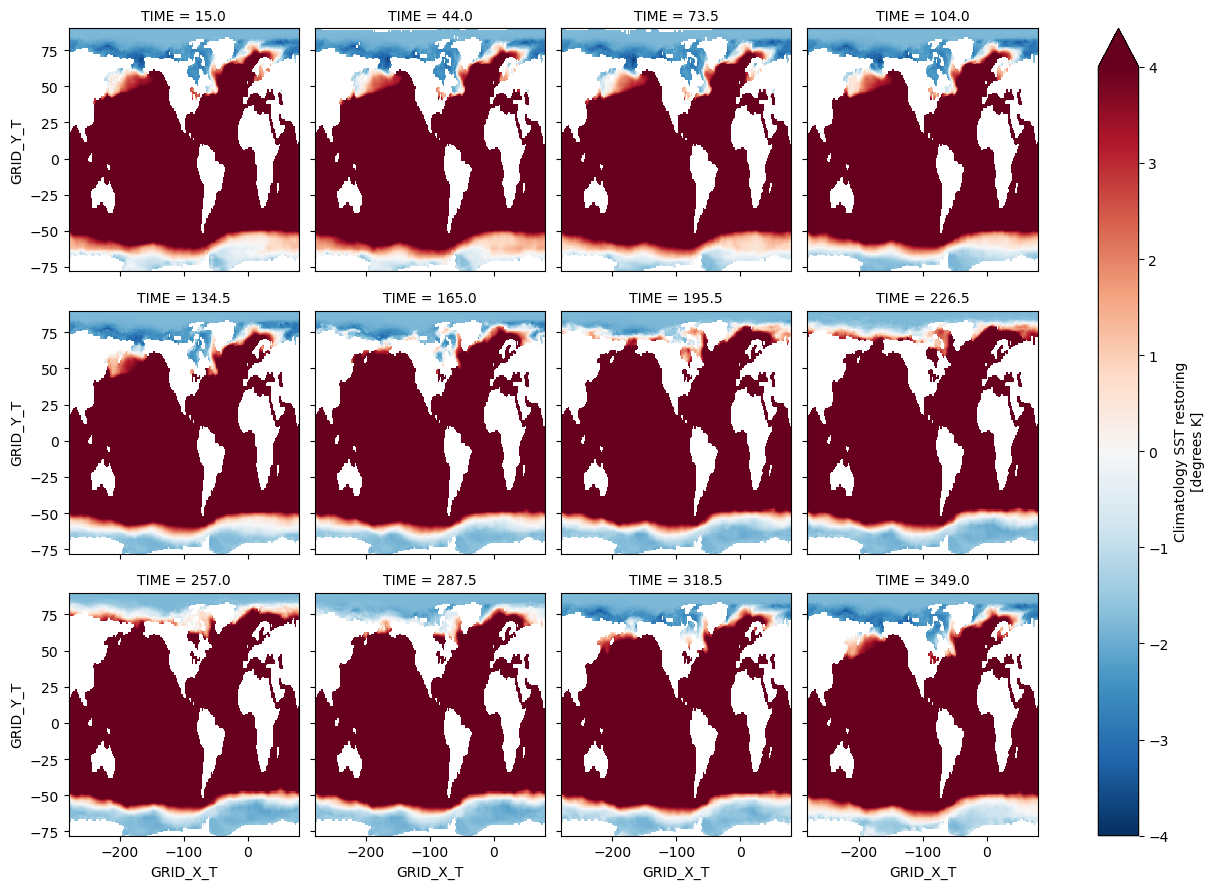

In [52]:
(regrid_coast['temp'])[0].plot(col = 'TIME', col_wrap = 4, vmin = -4, vmax = 4, cmap = 'RdBu_r')

In [55]:
test = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology.nc", decode_times=False)

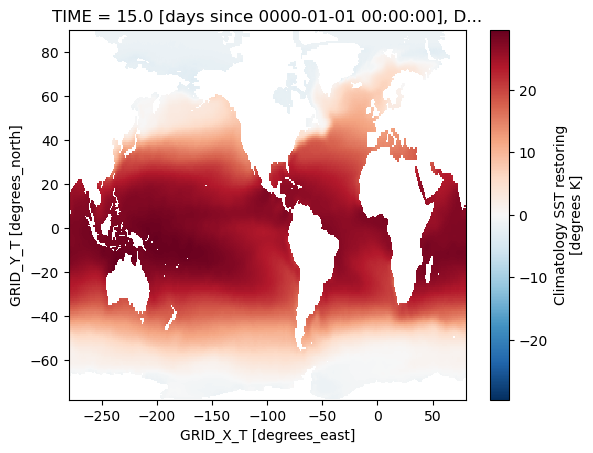

In [57]:
test.temp[0,0].plot()

In [84]:
#look at detrending by month out of interest

In [59]:
np.where(da['time.year']==1900)[0][0]

0

In [63]:
months = [1, 2, 3, 4,5,6,7,8,9,10,11, 12]
years = da.groupby('time.year').mean('time').year

# Convert the month and year values to the corresponding time indices
mon_ind={}
for mon in months:
    indices = [np.where(da['time.year']==year)[0][mon-1] for year in years]
    mon_ind[mon] = indices

da_mon = {}
for mon in months:
    da_ = da.isel(time=mon_ind[mon])
    da_mon[mon] = da_

In [66]:
#add times back to 1850 to fill in later
new_time = pd.date_range('1850-01-16', '1900-01-16', freq='M')

# create a new data array with zeros and the same dimensions as the original array
new_data = np.zeros((len(new_time)))
new_data[:] = np.nan #delete if i want to go back to zeros in middle

# create a new xarray DataArray with the new time index and the zero-filled data
new_array = xr.DataArray(new_data, coords=[new_time], dims=['time'])

# concatenate the new array with the original array along the time dimension
concatenated_array = xr.concat([new_array, da], dim='time')

In [67]:
# create a new time coordinate with monthly frequency for the years 1780-1800
new_times = pd.date_range(start='1680-01', end='1850-1', freq='M')
# create a new DataArray with the time coordinate and fill with NaNs
da_1680_1849 = xr.DataArray(data=np.nan, dims=('time', 'lat', 'lon'), coords={'time': new_times})

# select the slice of data from 1900 to 2020
da_1850_2020 = concatenated_array.sel(time=slice('1850-01-01', '2019-12-31'))

# reverse the order of the data along the time axis
da_1680_1849_data = da_1850_2020.isel(time=slice(None, None, -1))

# update the time coordinate to reflect the new time period
da_1680_1849_data['time'] = new_times

# reindex the data to add the new months from 1780-1800
da_1680_1849_data = da_1680_1849_data.reindex(time=da_1680_1849.time)

# concatenate the three slices along the time axis to get the final DataArray
da_symmetric = xr.concat([da_1680_1849_data, da_1850_2020], dim='time')

In [68]:
da = da_symmetric
months = [1, 2, 3, 4,5,6,7,8,9,10,11, 12]
years = da.groupby('time.year').mean('time').year

# Convert the month and year values to the corresponding time indices
mon_ind={}
for mon in months:
    indices = [np.where(da['time.year']==year)[0][mon-1] for year in years]
    mon_ind[mon] = indices

da_mon = {}
for mon in months:
    da_ = da.isel(time=mon_ind[mon])
    da_mon[mon] = da_

In [70]:
q

<xarray.Dataset>
Dimensions:               (latitude: 180, longitude: 360, time: 340)
Coordinates:
  * latitude              (latitude) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * longitude             (longitude) float64 -179.5 -178.5 ... 178.5 179.5
  * time                  (time) datetime64[ns] 1680-01-31 ... 2019-01-16T12:...
Data variables:
    polyfit_coefficients  (time, latitude, longitude) float64 nan ... 7.606e-09

In [71]:
plt.figure(figsize(10,12))

for mon in months:
    da = da_mon[mon]
    pv = da.polyfit(dim = 'time', deg = 2)
    q = xr.polyval(da.time, pv)
    delta_q =  q.polyfit_coefficients[-(15)-1] - q.polyfit_coefficients[170]


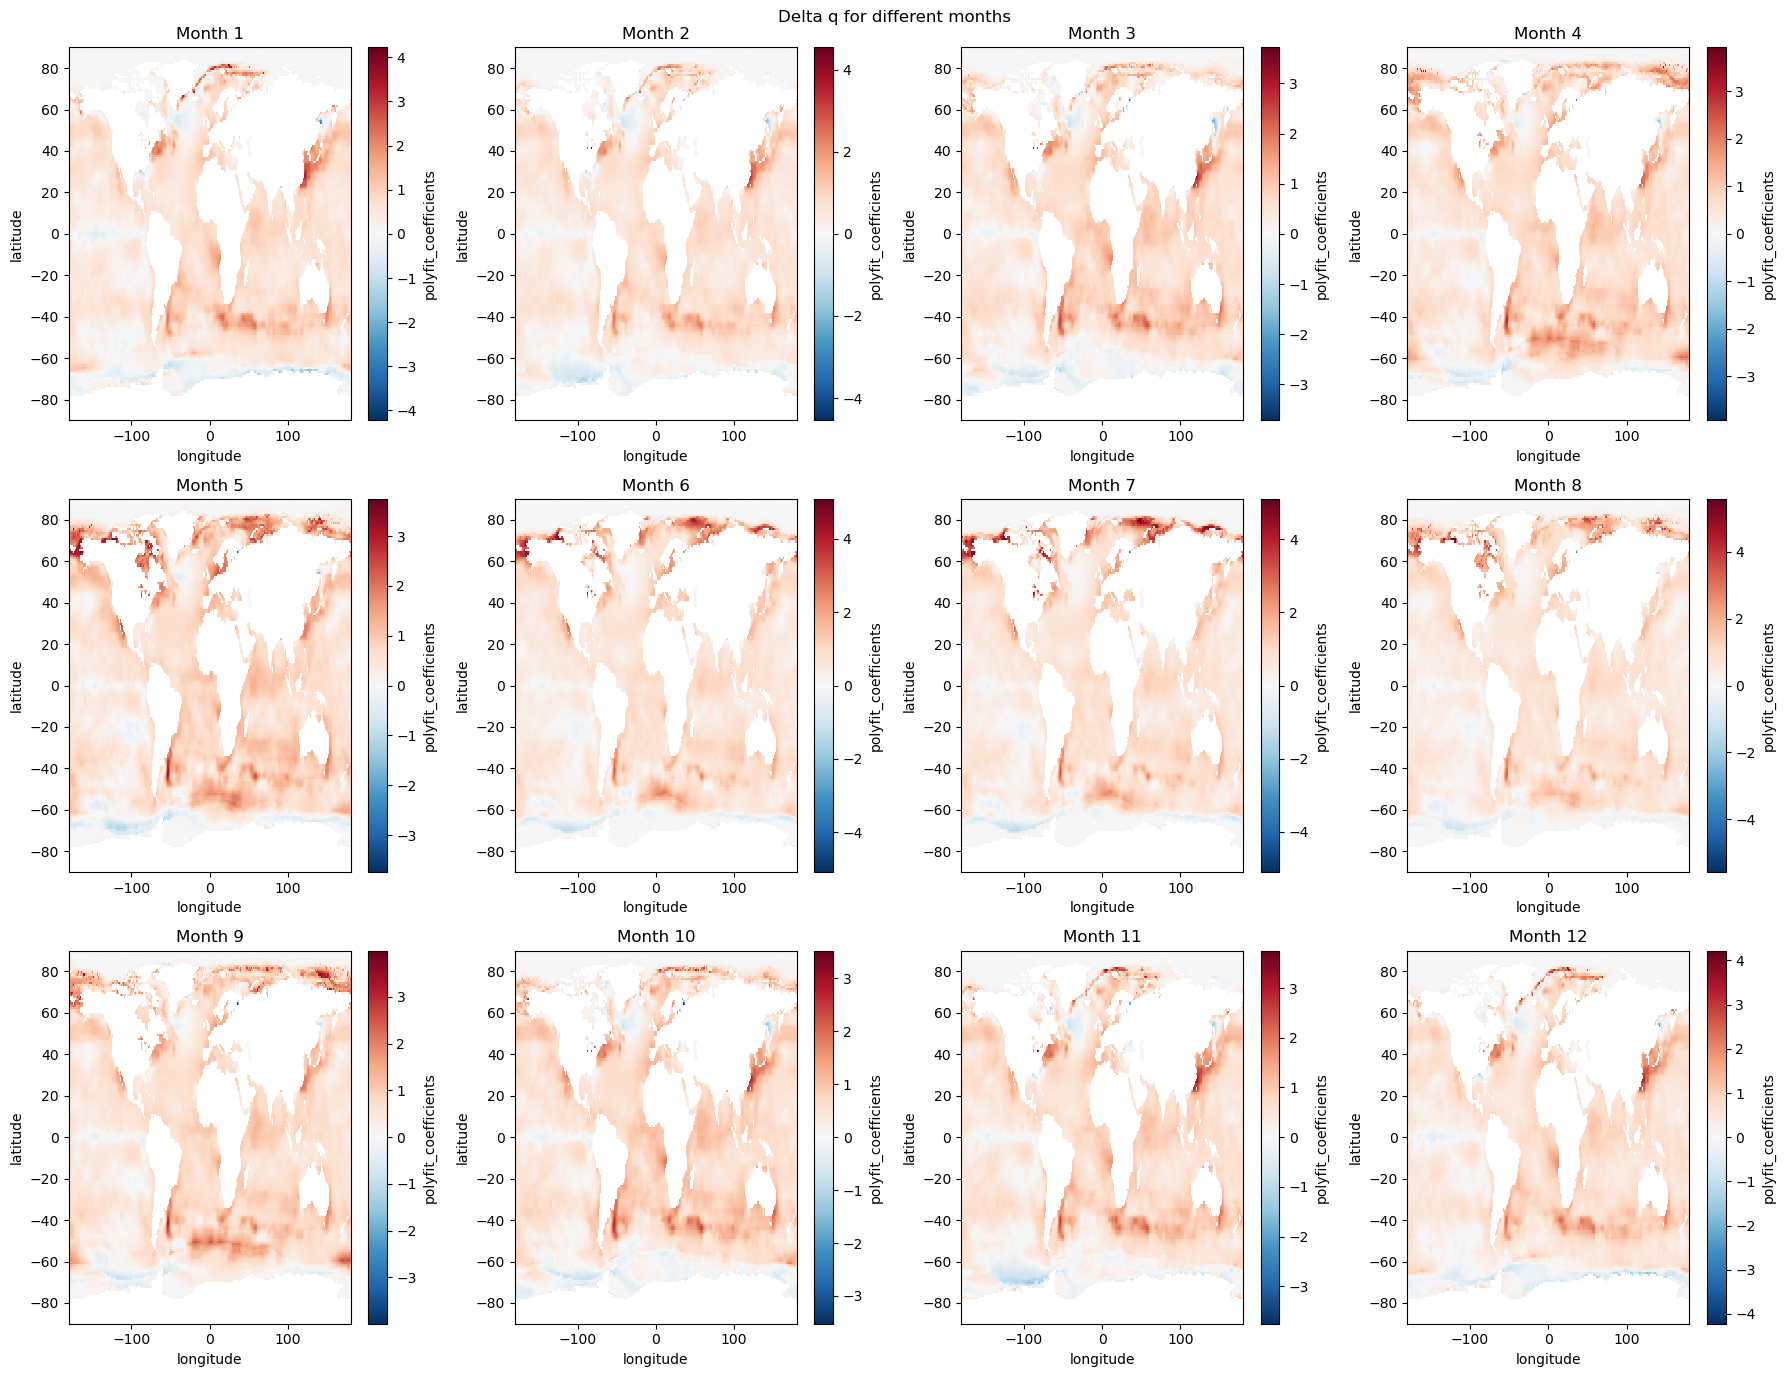

In [75]:
fig, axs = plt.subplots(3, 4, figsize=(18, 14))
for i, mon in enumerate(months):
    # Get the data for the current month
    da = da_mon[mon]
    pv = da.polyfit(dim='time', deg=2)
    q = xr.polyval(da.time, pv)
    delta_q = q.polyfit_coefficients[-(15)-1] - q.polyfit_coefficients[170]
    
    # Compute the subplot indices for the current month
    row = i // 4
    col = i % 4
    
    # Plot the data in the corresponding subplot
    delta_q.plot(ax=axs[row, col])
    axs[row, col].set_title(f'Month {mon}')
    
# Add a title for the entire plot
fig.suptitle('Delta q for different months')
fig.tight_layout()

In [ ]:
pv = da_symmetric.polyfit(dim = 'time', deg = 2)
#this fits a polynomial of degree 2 to the symetric dataset

In [ ]:
q = xr.polyval(da_symmetric.time, pv)
delta_q =  q.polyfit_coefficients[-(15*12)-1] - q.polyfit_coefficients[12*170]

In [ ]:
mod_clim = hadsst1.sel(time=slice("1990-01-01", "2019-12-31")).groupby('time.month').mean('time')

In [ ]:
detrend = mod_clim-delta_q